# Problem Statement 5

In [1]:
%autosave 10

Autosaving every 10 seconds


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

### Import the cleaned data set. Then, select the features from the DataFrame of the case study data.

#### These features should be: 'LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', AND 'PAY_AMT6'.

In [3]:
# Import data set
df = pd.read_csv("cleaned_data.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_CAT,graduate school,high school,others,university
0,798fc410-45c1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,1,university,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,1,university,0,0,0,1
2,85698822-43f5,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0,university,0,0,0,1
3,0737c11b-be42,50000,2,2,1,37,0,0,0,0,...,1200,1100,1069,1000,0,university,0,0,0,1
4,3b7f77cc-dbc0,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0,university,0,0,0,1


In [4]:
# Create features list
features_response = ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 
                     'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                     'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                     'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']

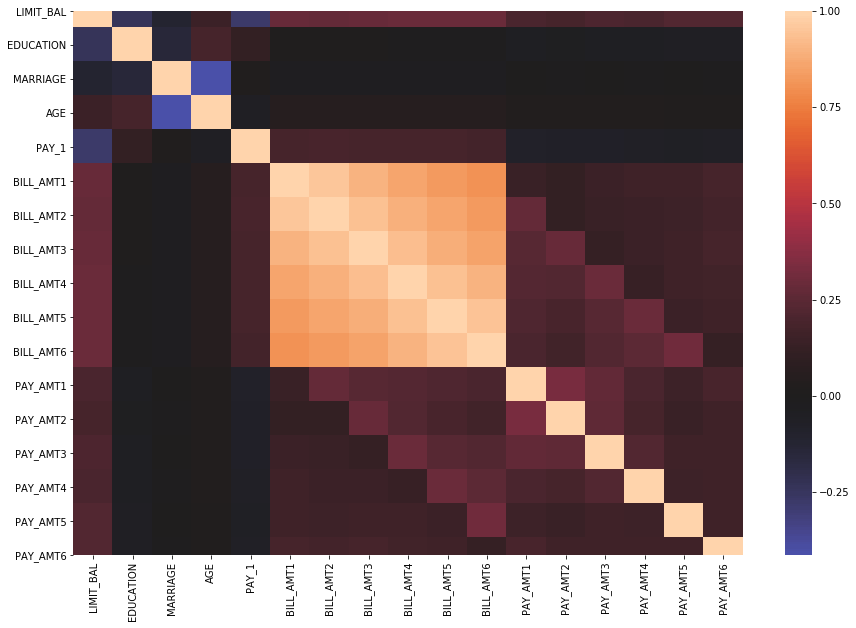

In [5]:
corr = df[features_response].corr()

plt.figure(figsize = (15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0)
plt.show()

In [7]:
X = df[features_response]
y = df['default payment next month']
X.shape, y.shape

((26664, 17), (26664,))

## Make a 80:20 train/test split using a random seed of 24.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state = 24)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21331, 17), (21331,), (5333, 17), (5333,))

### Performing Stratified KFold cross Validation on Synthetic Data

In [9]:
C_val_exponents = np.linspace(3,-3,13)
print(C_val_exponents)

C_vals = np.float(10)**C_val_exponents
print(C_vals)

[ 3.   2.5  2.   1.5  1.   0.5  0.  -0.5 -1.  -1.5 -2.  -2.5 -3. ]
[1.00000000e+03 3.16227766e+02 1.00000000e+02 3.16227766e+01
 1.00000000e+01 3.16227766e+00 1.00000000e+00 3.16227766e-01
 1.00000000e-01 3.16227766e-02 1.00000000e-02 3.16227766e-03
 1.00000000e-03]


In [10]:
from sklearn.metrics import roc_curve

In [11]:
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
            
        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X_synthetic, y_synthetic = make_classification(
    n_samples=1000, n_features=200,
    n_informative=3, n_redundant=10,
    n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=None,
    flip_y=0.01, class_sep=0.8,
    hypercube=True, shift=0.0,
    scale=1.0, shuffle=True,
    random_state=24
)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
    X_synthetic, y_synthetic,
    test_size=0.2, random_state=24
)

lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)

n_folds = 4

k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


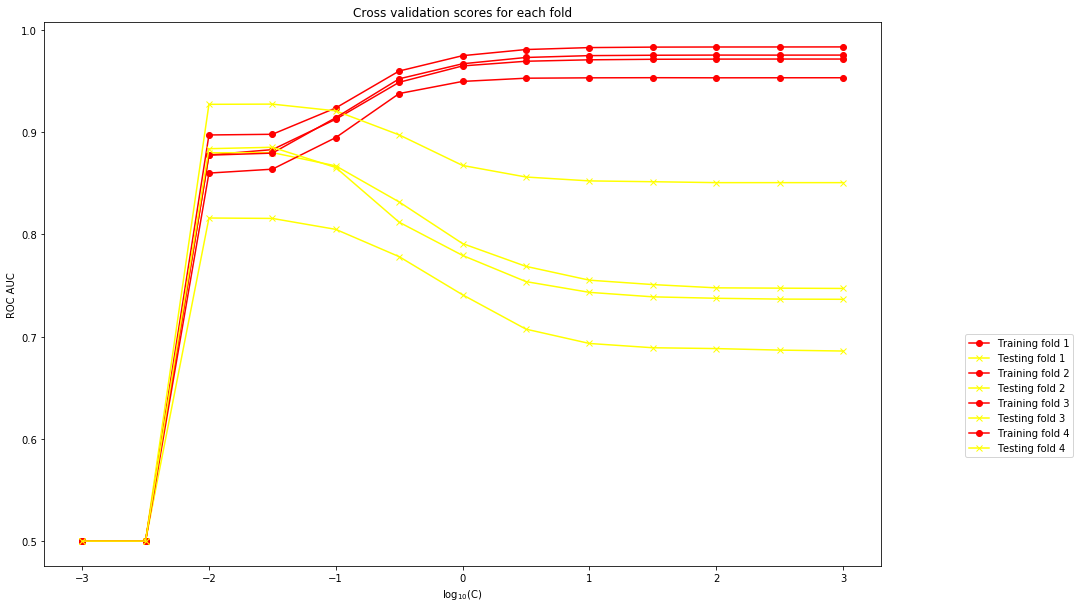

In [13]:
plt.figure(figsize = (15,10))

for this_fold in range(n_folds):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color='red', label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color='yellow', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')
plt.show()

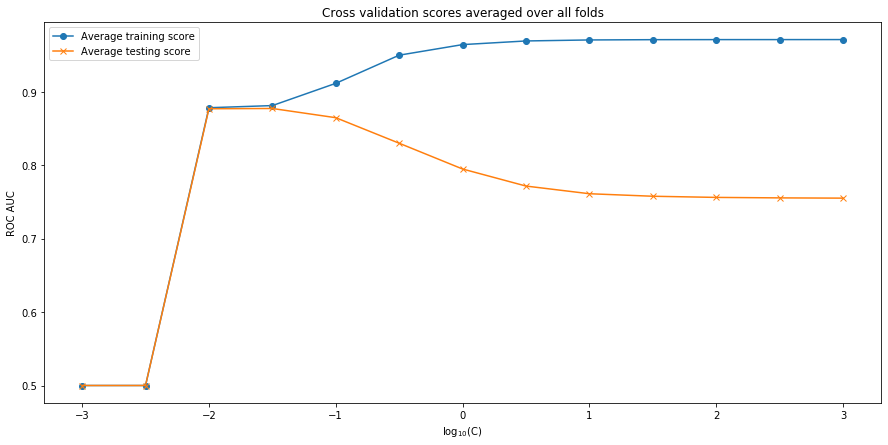

In [14]:
plt.figure(figsize = (15,7))
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

In [15]:
# Code to locate the c value where exponent is -1.5
best_C_val_bool = C_val_exponents == -1.5
best_C_val_bool.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [16]:
best_C_val_ix = np.argmax(best_C_val_bool)
best_C_val_ix

9

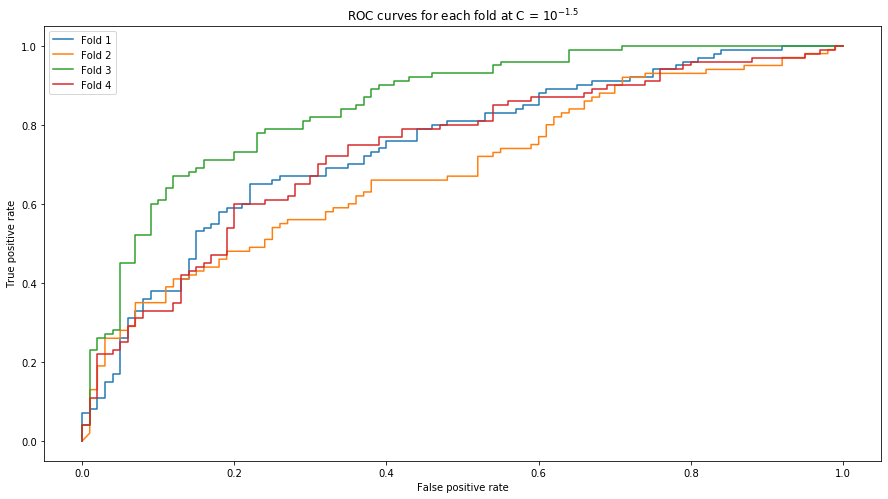

In [17]:
plt.figure(figsize = (15,8))
for this_fold in range(n_folds):
    fpr = cv_test_roc[best_C_val_ix][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()
plt.show()

In [18]:
lr_syn.C = 10**(-1.5)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
print(f"Test Set AUC ROC Score: {roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])}")

Test Set AUC ROC Score: 0.8802812499999999


In [20]:
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
print(f"Train Set AUC ROC Score: {roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])}")

Train Set AUC ROC Score: 0.8847884788478848


In [21]:
sum((lr_syn.coef_ != 0)[0])

2

In [22]:
lr_syn.intercept_

array([0.])

## Instantiate the MinMaxScaler to scale the data.

In [23]:
from sklearn.preprocessing import MinMaxScaler

min_max_sc = MinMaxScaler()

## Instantiate a logistic regression model with the saga solver, L1 penalty, and set max_iter to 1,000 as we want the solver to have enough iterations to find a good solution.

In [24]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver = 'saga', penalty = 'l1', max_iter = 1000)
lr_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

## Import the Pipeline class and create a Pipeline with the scaler and the logistic regression model, using the names 'scaler' and 'model' for the steps, respectively.

In [25]:
from sklearn.pipeline import Pipeline

scale_lr_pipeline = Pipeline(steps = [('scaler',min_max_sc), ('model', lr_model)])


## Use the get_params method to view the parameters from each stage of the pipeline.

In [26]:
# Use `get_params`
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('model',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=1000,
                      multi_class='warn', n_jobs=None, penalty='l1',
                      random_state=None, solver='saga', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fi

### Use the set_params method to change the the model__C parameter to 2.

In [27]:
# View what `model__C` is set to currently
scale_lr_pipeline.get_params()['model__C']

1.0

In [28]:
# Change `model__C` to 2
scale_lr_pipeline.set_params(model__C = 2.0)
scale_lr_pipeline.get_params()['model__C']

2.0

### Then, create a smaller range of C values to test with cross-validation, as these models will take longer to train and test with more data than our previous activities.

Use C_vals = [$10^2$, $10$, $1$, $10^{-1}$, $10^{-2}$, $10^{-3}$].

In [29]:
C_val_exponents = np.linspace(2,-3,6)
print(C_val_exponents)

C_vals = np.float(10)**C_val_exponents
print(C_vals)

[ 2.  1.  0. -1. -2. -3.]
[1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03]


In [30]:
k_folds = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 1)

### Next, make a new version of the cross_val_C_search function, called cross_val_C_search_pipe. Instead of the model argument, this function will take a pipeline argument. The changes inside the function will be to set the C value using set_params(model__C = <value you want to test>) on the pipeline, replacing the model with the pipeline for the fit and predict_proba methods, and accessing the C value using pipeline.get_params()['model__C'] for the printed status update.

In [31]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline_model, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        
        #Set the C value for the model object
        pipeline_model.set_params(model__C = C_vals[c_val_counter])
        
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            
            #Subset the features and response, for training and testing data for
            #this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            pipeline_model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = pipeline_model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = pipeline_model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
            
        #Indicate progress
        print('Done with C = {}'.format(pipeline_model.get_params()['model__C']))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc


### Now, run this function as in the previous activity, but using the new range of C values, the pipeline you created, and the features and response variable from the training split of the case study data.

In [32]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


### Plot the average training and testing ROC AUC across folds, for each np.log(C_vals) value.

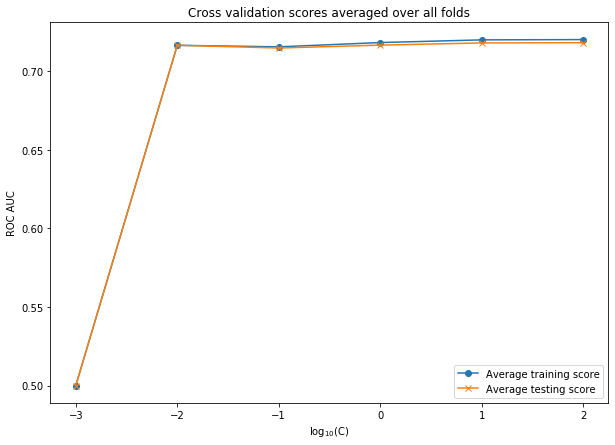

In [33]:
plt.figure(figsize = (10,7))
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

### Up next, create interaction features for the case study data using scikit-learn's PolynomialFeatures. You should use 2 as the degree of polynomial features. Confirm that the number of new features makes sense.

In [34]:
from sklearn.preprocessing import PolynomialFeatures

make_interactions = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

poly_X = make_interactions.fit_transform(X)

poly_X.shape

(26664, 153)

### Finally, repeat the cross-validation procedure and observe the model performance now.

In [35]:
# Using the new features, make a 80:20 train/test split using a random seed of 24.**
X_train, X_test, y_train, y_test = train_test_split(poly_X, y.values, test_size = 0.2, random_state = 24)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21331, 153), (21331,), (5333, 153), (5333,))

In [37]:
# Call the cross_val_C_search_pipe() function using the new training data.
# All other parameters should remain the same.
# Note that this training may take a few minutes due to the larger number of features.
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 100.0


C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 10.0


C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Kumbhkaran\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


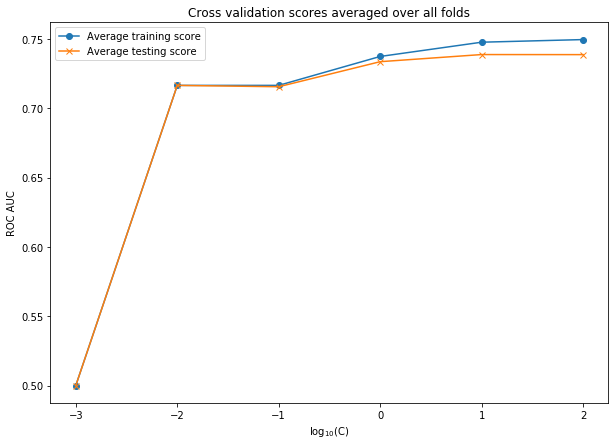

In [38]:
# Plot the average training and testing ROC AUC across folds, for each C value.
plt.figure(figsize = (10,7))
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')
plt.show()

#### Take a look at the above graph. Does the average cross-validation testing performance improve with the interaction features? Is regularization useful?
OBSERVATION: After comparing the cross validation graph over all folds with interation features and without interaction features, we can see a significant increase in the ROC AUC score in the cross validation graph with interaction features.